In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import obspy
import librosa
import resampy

import os.path

In [59]:
DirCatalog = '/home/ben/githole/earthquack/projects/catalog_movies/quakes/kilauea_2018/'
FileCatalog = 'EQ_Eruption_Catalog_4_1_2018_8_30_2018_HVO_validdata.csv'

#tab = pd.read_csv(DirCatalog + FileCatalog, header=None, delimiter=',', \
#                 names = ['years','months','days','hours','minutes','seconds','lat','lon','dep','mag','degrees','id'])

names_vec = ['time','lat','lon','dep','mag','degrees','id', 'type', 'error1', 'error2', 'error3','valid']
tab = pd.read_csv(DirCatalog + FileCatalog, header=None, delimiter=',', names=names_vec)
        

print('The catalog is a dataframe of size ' + str(tab.shape))

print('I will assume (correct me if I\'m wrong) that the fields are:\n\t year\n\t month\n\t day\n\t hour\n\t minute\n\t seconds\n\t latitude\n\t longitude\n\t depth\n\t magnitude\n\t id')

print('There are ' + str(len(tab['time'])) + ' events')

The catalog is a dataframe of size (41329, 12)
I will assume (correct me if I'm wrong) that the fields are:
	 year
	 month
	 day
	 hour
	 minute
	 seconds
	 latitude
	 longitude
	 depth
	 magnitude
	 id
There are 41329 events


In [60]:
# DirCatalog = 'data/'
DirData = '/home/ben/data/Kilauea/eqcatalogdata/'  # for waveforms, add /AL4Catalog = '/Volumes/linux/ML_data/NWGeysers/GeysersNW_data/'
#DataFile = 'top100k.txt'
#DataFile = 'Kilauea_eq_OBL.txt'

#datamat = np.loadtxt(DirData+DataFile, delimiter=',', skiprows=1)
#print(datamat.shape)


In [61]:
obspy.UTCDateTime(tab.time[0])
#tab.time[0]

2018-04-01T06:59:02.810000Z

time 2018-08-30T22:31:16.570Z


Text(0, 0.5, 'start time (data time, s)')

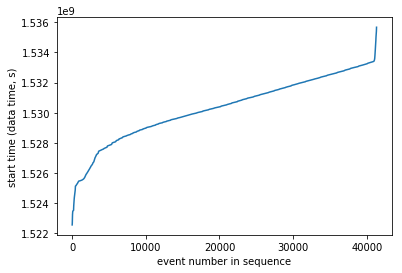

In [62]:
# Get the start time of each event as a timestamp
starttimes = np.zeros(len(tab['time']))
for k in range(0,len(tab['time'])-1):
    starttimes[k] = obspy.UTCDateTime(tab['time'][k]).timestamp
    
tab['starttimes'] = pd.Series(starttimes) # and put it in the dataframe
print(tab['time'].iloc[0],tab['time'].iloc[-1])
plt.plot(tab['starttimes'])
plt.xlabel('event number in sequence')
plt.ylabel('start time (data time, s)')

There are 41329 events left


Text(0, 0.5, 'start time (movie time, s)')

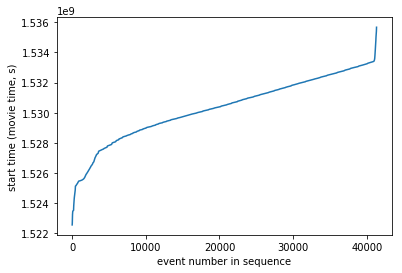

In [63]:
# Sort the dataframe according to time stamps
tab = tab.sort_values(by=['starttimes'])

# And reset indices
tab = tab.reset_index()
NbEvents = len(tab['time'])
print('There are ' + str(NbEvents) + ' events left')

plt.plot(tab.starttimes)
plt.xlabel('event number in sequence')
plt.ylabel('start time (movie time, s)')

In [64]:
print(type(tab['mag'][0]))

<class 'str'>


In [65]:
# Get rid of events of lower magnitude
minMag = 1.5
tab.mag = pd.to_numeric(tab.mag, errors='coerce')
tab = tab.drop(tab[tab['mag'] < minMag].index)
N_evts = len(tab['mag'])
print('There remain ' + str(N_evts) + ' events')
maxMag = np.amax(tab['mag'])
print('The biggest is ' + str(maxMag))

# And reset indices

tab = tab.reset_index()

#print(tab)

There remain 40964 events
The biggest is 6.9


6.9


Text(0, 0.5, 'magnitude')

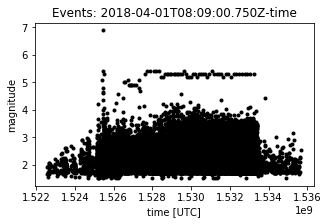

In [66]:
fig = plt.figure(figsize = (5,3))
titletext = 'Events: ' + str(tab['time'].iloc[0])+ '-' + str(tab['time'].iloc[-1])

istart = 0 # 10000
interval = len(tab)-1 # 2000

maxMag = np.amax(tab['mag'][istart:istart+interval])
print(maxMag)

#plt.plot(time_years,tab['mag'],'.k')
plt.plot(tab['starttimes'][istart:istart+interval],tab['mag'][istart:istart+interval],'.k')
plt.title(titletext)
plt.xlabel('time [UTC]')
plt.ylabel('magnitude')

In [67]:
fig_path = './'
figname_map = fig_path + 'catalog_plot' +'.png'
fig.savefig(figname_map, pad_inches=0.0, bbox_inches='tight', dpi=300)

# Movie parameters

In [68]:
#movie_duration = 30.0 # in seconds
movie_duration = 100.0*interval/len(tab.id) # in seconds
print(movie_duration)
movie_dt = 1/29.97 #0.1 # in seconds
movie_t = np.arange(0,movie_duration,movie_dt) 
# what is this movie dt ?  10 frames per sec? 

99.9975588321453


In [69]:
# rescale data start times to movie time
max_starttime = np.amax(tab['starttimes'][istart:istart+interval]-tab['starttimes'][istart])
movie_starttimes = (tab['starttimes'][istart:istart+interval]-tab['starttimes'][istart])*movie_duration/max_starttime
#print(movie_starttimes)

# Sound parameters

In [70]:
real_event_dur = 70.0 # seconds
new_event_dur = 0.4 # seconds  0.1 is too fast
SpeedFactor = real_event_dur/new_event_dur
print(SpeedFactor)

audio_sr = 44100

SoundTrack = np.zeros((2,int(movie_duration*audio_sr)))
ch_l = np.zeros(int(movie_duration*audio_sr))
ch_r = np.zeros(int(movie_duration*audio_sr))
print(len(ch_l))

175.0
4409892


In [71]:
#DirData = DirCatalog + 'AL4/'
data_sr = 100.
print(DirData)

/home/ben/data/Kilauea/eqcatalogdata/


In [72]:
N_evts

40964

In [73]:
data = np.loadtxt(DirData + 'hv70068046.txt',delimiter=',', skiprows=1)
data[:,1]

array([ 0.        ,  0.02124767,  0.0890996 , ...,  0.05512044,
        0.01406281,  0.        ])

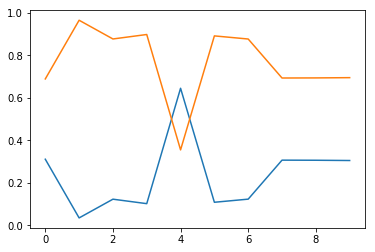

In [74]:
tab.lon = pd.to_numeric(tab.lon, errors='coerce')

stereo_r = (tab.lon-min(tab.lon))/(max(tab.lon)-min(tab.lon))
stereo_l = 1-stereo_r
plt.plot(stereo_r[0:10])
plt.plot(stereo_l[0:10])

233 files not found


Text(0.5, 1.0, 'Speedfactor = 175.0, sr = 100.0Hz')

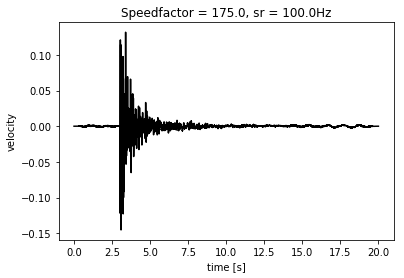

In [75]:
filenotfoundlist = []

# ANY SCALING OF THE AMPLITUDE BY MAGNITUDE 
# or are all sounds normalized to same value ? 


for k in range(istart,istart+interval): #(0,N_evts-1): #range(100,101): #
#for k in range(0,50):

    current_id = tab['id'][k]
    #print(current_id)

    # Build the name of the file to load
#     currentjulday = obspy.UTCDateTime(tab['starttimes'][k]).julday
#     current_filename = makefilenamestring(currentjulday)
    current_filename = current_id+'.txt'
    
    if os.path.exists(DirData + current_filename): # Test if file exists
        #print(current_filename)
        # Test if the data is not going beyond the limits we set for the sound track
        # FIX this so that there is extra time at the end ! 
        if movie_starttimes[k]+real_event_dur/SpeedFactor < movie_duration: 
            # Load data
            data = np.loadtxt(DirData + current_filename,delimiter=',', skiprows=1)
            data = data[:,1]

            if len(data) > .75*(real_event_dur*data_sr): # Process only if the data is long enough (entire data should be 20 s @ 500 Hz)
                #data = data - np.mean(data) # de-mean
                data = data/np.amax(np.absolute(data)) # normalize
                #data = data*(tab['mag'][k]/(2*maxMag)) # TEST -- linear mapping of magnitude to amplitude 
                data = data*np.interp(tab['mag'][k],[minMag,maxMag],[0.001,1])
                data_l = data*stereo_l[k]
                data_r = data*stereo_r[k]
                
                #t_data = np.arange(0,len(data)/data_sr,1/data_sr)
                #plt.plot(t_data,data)
                #plt.xlabel('t (s)')

                data_resampled_l = resampy.resample(data_l, data_sr*SpeedFactor, audio_sr) # resample to audio rate
                data_resampled_r = resampy.resample(data_r, data_sr*SpeedFactor, audio_sr) # resample to audio rate
                #t_resampled = np.arange(0,len(data_resampled)/audio_sr,1/audio_sr)
                #plt.plot(t_resampled,data_resampled)

                # Fill the appropriate part of the sound track with the newly audified data
#                 SoundTrack[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled))] = \
#                     SoundTrack[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled))] + data_resampled

                ch_l[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_l))] = \
                    ch_l[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_l))] + data_resampled_l
    
                ch_r[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_r))] = \
                    ch_r[int(movie_starttimes[k]*audio_sr):int(movie_starttimes[k]*audio_sr+len(data_resampled_r))] + data_resampled_r
        else:
            balbal = 2
            #print('\t Not processing file ' + current_filename + ' because it would exceed the length of the soundtrack')
    else:
        #print('File ' + current_filename + ' does not exist...')
        filenotfoundlist.append(current_filename)
        
        
print(str(len(filenotfoundlist))+' files not found')

fig = plt.figure(figsize = (6,4))
sigtime = np.linspace(0,20.0,len(data))  
plt.plot(sigtime,data, 'k')
titletext = 'Speedfactor = ' + str(SpeedFactor)+ ', sr = ' + str(data_sr) + 'Hz'
plt.xlabel('time [s]')
plt.ylabel('velocity')
plt.title(titletext)

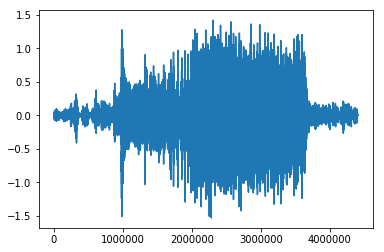

In [76]:
plt.plot(ch_l)
plt.savefig('ch_l_0.001:1_maxmag5.3.png')

In [77]:
SoundTrack[0,:] = ch_l
SoundTrack[1,:] = ch_r

# And export the sound file

In [78]:
#DirOut = DirCatalog
DirOut = './'
filenameforexport = 'Kilauea2018_full1.wav'
SoundTrack = SoundTrack/np.amax(SoundTrack)# normalize
librosa.output.write_wav(DirOut + filenameforexport, SoundTrack, audio_sr, norm=True)

In [ ]:


# nfiles = len(tab.valid)
# print(nfiles)
# print(type(tab.valid.iloc[12]))

# count = 0
# for i in range(1,nfiles):
#     validity = int(tab.valid.iloc[i])
#     if validity==1:
#         count += 1

# print(count)




In [ ]:
# npts = 7000
# ntot = len(datamat)
# nfiles = int(np.floor(ntot/(npts-1)))

# print(nfiles)

In [ ]:
# nfiles_cat = len(tab.id)
# print(nfiles_cat)
# count = 0

# for i in range(1,nfiles_cat-1):
#     validity = int(tab.valid.iloc[i])
#     if validity==1:        
#         start = count*npts
#         fin = start+npts
#         #print(start,fin)
#         time = datamat[start:fin,0]
#         #print(time[0])
#         trace = datamat[start:fin,1] 
#         name = tab.id[i] + '.txt'
#         np.savetxt(DirData+'waveforms_test/'+name, trace)
        
#         count += 1
        
# print(count)